In [1]:
# Dependencies
import requests
import pandas as pd

# import plotly.graph_objects as go
import datetime as DT
import numpy as np

import matplotlib.pyplot as plt

In [2]:
url = "https://covidtracking.com/api/v1"

# Current state data - /api/v1/states/current 
region = "states"
time = "current"
state_current = requests.get(f"{url}/{region}/{time}.json").json()

# Historic state data - /api/v1/states/daily 
region = "states"
time = "daily"
state_daily = requests.get(f"{url}/{region}/{time}.json").json()

# Current US data - /api/v1/us/current
region = "us"
time = "current"
us_current = requests.get(f"{url}/{region}/{time}.json").json()

# Historic US data - /api/v1/us/daily
region = "us"
time = "daily"
us_daily = requests.get(f"{url}/{region}/{time}.json").json()

In [3]:
# https://api.census.gov/data/2019/pep/population.html
# https://www.census.gov/data/developers/data-sets/popest-popproj/popest.Vintage_2019.html

pop_url = "https://api.census.gov/data/2019/pep/population?get=STATE,POP,NAME&for=state:*"
pop_state = requests.get(f"{pop_url}").json()
# pop_state

In [4]:
pop_df = pd.DataFrame(pop_state, columns = pop_state[0]) 
pop_df = pop_df.drop(pop_df.index[0])
# pop_df.head()

In [12]:
states_dict = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [5]:
# The following fields are deprecated and are no longer being updated with new data.

# /api/v1/states/current.json:

# positiveScore
# negativeScore
# negativeRegularScore
# commercialScore
# score
# grade - Use dataQualityGrade instead
# total
# /api/v1/us/current.json

# posNeg
# total

### State Daily Data Cleaning

In [6]:
state_daily_df = pd.DataFrame(state_daily) 

# checking for null date values
state_daily_df[state_daily_df['date'].isnull()]

state_daily_df['year'] = state_daily_df['date'].astype('str').str[:4]
state_daily_df['month'] = state_daily_df['date'].astype('str').str[4:6]
state_daily_df['day'] = state_daily_df['date'].astype('str').str[6:]
state_daily_df ['date'] = state_daily_df['month']+"/"+state_daily_df['day']+"/"+state_daily_df['year']
state_daily_df ['date'] = pd.to_datetime(state_daily_df['date'], format='%m/%d/%Y')

state_daily_df.columns = map(str.lower, state_daily_df.columns)
select_columns = ['date', 'state','negative', 'totaltestresults']
state_daily_df= state_daily_df[select_columns]
state_daily_df

,date,state,negative,totaltestresults
0,2020-05-16,AK,32889.0,33281
1,2020-05-16,AL,141971.0,153494
2,2020-05-16,AR,77066.0,81644
3,2020-05-16,AS,105.0,105
4,2020-05-16,AZ,133157.0,146788
...,...,...,...,...
4044,2020-01-26,WA,NaN,1
4045,2020-01-25,WA,NaN,1
4046,2020-01-24,WA,NaN,1
4047,2020-01-23,WA,NaN,1


In [13]:
state_daily_df['state_name']=state_daily_df['state'].map(states_dict)
# state_daily_df[state_daily_df['state_name'].isnull()]

# state_current_pop_df = 
state_daily_df = pd.merge (state_daily_df, pop_df, how = "outer", left_on = ["state_name"], right_on = ["NAME"] )
state_daily_df[state_daily_df['NAME'].isnull()]

# current API call for population is lacking data from American Samoa, Guam, Northern Mariana Islands, Virgin Islands.
state_daily_df = state_daily_df[state_daily_df['NAME'].isnull() == False]

state_daily_df = state_daily_df.rename(columns = {"state_x": "state",
                                      "POP": "2019 population"})

select_columns = ['date', 'state', 'negative', 'totaltestresults', "2019 population"]
state_daily_df= state_daily_df[select_columns]


state_daily_df.head()

,date,state,negative,totaltestresults,2019 population
0,2020-05-16,AK,32889.0,33281,731545
1,2020-05-15,AK,32030.0,32418,731545
2,2020-05-14,AK,31375.0,31762,731545
3,2020-05-13,AK,30266.0,30649,731545
4,2020-05-12,AK,29578.0,29961,731545


In [14]:
state_daily_df ['tests per 1000'] =  state_daily_df['totaltestresults'].astype(int)/state_daily_df['2019 population'].astype(int)*1000

state_daily_df
# drops NA for negative ... which is PR on 5/16/2020
state_daily_df = state_daily_df.dropna(subset = ['negative'])
state_daily_df['negatives per test'] = state_daily_df['negative'].astype(int)/state_daily_df['totaltestresults'].astype(int)

In [15]:
# "avg works because there isn't more than one value per crosssection"
state_daily_pivot=state_daily_df.pivot_table(index=['state'], values = 'tests per 1000', columns = "date", aggfunc = 'mean')

In [16]:
today = pd.to_datetime('today')
last_week = today - DT.timedelta(days=7)
last_week.date(), today.date()

last_ten_weeks = []

for i in range (10):
    delta = 7*(i)
    delta_date = today - DT.timedelta(days=delta)
        
#     last_ten_weeks.append(delta_date.date().strftime("%Y-%m-%d"))
    last_ten_weeks.append(delta_date.date())
#
    print (delta_date)
last_ten_weeks

2020-05-16 20:05:14.165434
2020-05-09 20:05:14.165434
2020-05-02 20:05:14.165434
2020-04-25 20:05:14.165434
2020-04-18 20:05:14.165434
2020-04-11 20:05:14.165434
2020-04-04 20:05:14.165434
2020-03-28 20:05:14.165434
2020-03-21 20:05:14.165434
2020-03-14 20:05:14.165434


[datetime.date(2020, 5, 16),
 datetime.date(2020, 5, 9),
 datetime.date(2020, 5, 2),
 datetime.date(2020, 4, 25),
 datetime.date(2020, 4, 18),
 datetime.date(2020, 4, 11),
 datetime.date(2020, 4, 4),
 datetime.date(2020, 3, 28),
 datetime.date(2020, 3, 21),
 datetime.date(2020, 3, 14)]

In [66]:
state_daily_pivot_final = state_daily_pivot[last_ten_weeks]
state_daily_pivot_final = state_daily_pivot_final.iloc[:, ::-1]
state_daily_pivot_final.columns = state_daily_pivot_final.columns.astype(str)
# pd.options.display.float_format = '{:,.2f}'.format
# pd.set_option('precision', 1)
state_daily_pivot_final

date,2020-03-14,2020-03-21,2020-03-28,2020-04-04,2020-04-11,2020-04-18,2020-04-25,2020-05-02,2020-05-09,2020-05-16
state,,,,,,,,,,
AK,0.20,1.06,3.99,8.26,10.57,13.20,21.51,29.25,36.15,45.49
AL,0.01,0.03,1.00,2.21,4.33,8.68,14.55,18.81,25.59,31.30
AR,0.03,0.23,1.11,3.44,6.16,8.00,12.61,17.09,21.71,27.05
AZ,0.02,0.05,1.14,3.73,5.57,7.01,8.59,10.72,14.54,20.17
CA,0.03,0.32,0.64,2.88,4.38,6.57,12.81,17.38,23.10,29.84
CO,0.12,0.64,2.03,3.83,5.67,7.52,9.86,13.36,16.80,21.16
CT,0.04,0.65,2.36,6.18,11.17,15.56,21.77,28.12,34.66,46.21
DC,0.08,0.83,3.56,9.12,14.22,18.80,24.52,31.18,39.93,50.35
DE,0.04,0.08,0.26,6.64,11.40,14.39,18.17,23.73,30.09,40.83


In [67]:
# def df_to_heatmap(df):
#     return {'z': df.values.tolist(),
#             'x': df.columns.tolist(),
#             'y': df.index.tolist()}

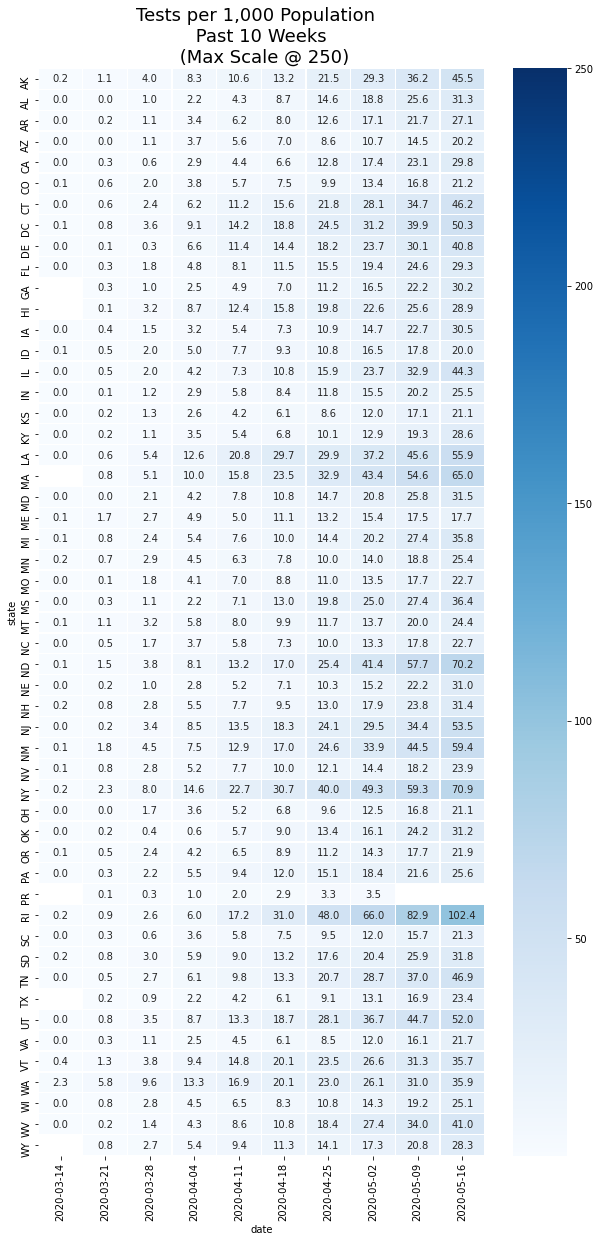

In [73]:
import seaborn as sns

max_scale = 250

fig, ax = plt.subplots(figsize=(10,20))
title = "Tests per 1,000 Population  \n Past 10 Weeks \n (Max Scale @ 250)"

plt.title(title, fontsize=18)

sns.heatmap(state_daily_pivot_final, cmap = 'Blues', linewidths = 0.30, annot =True, fmt = '.1f', ax=ax, vmax = max_scale)

plt.savefig("images/testsper1000")

plt.show()

### State Current Data Cleaning

In [65]:
state_current_df = pd.DataFrame(state_current) 
state_current_df
# Columns:
# ['state', 'positive', 'positiveScore', 'negativeScore',
#        'negativeRegularScore', 'commercialScore', 'grade', 'score', 'notes',
#        'dataQualityGrade', 'negative', 'pending', 'hospitalizedCurrently',
#        'hospitalizedCumulative', 'inIcuCurrently', 'inIcuCumulative',
#        'onVentilatorCurrently', 'onVentilatorCumulative', 'recovered',
#        'lastUpdateEt', 'checkTimeEt', 'death', 'hospitalized', 'total',
#        'totalTestResults', 'posNeg', 'fips', 'dateModified', 'dateChecked',
#        'hash']

state_current_df.columns = map(str.lower, state_current_df.columns)

# state_current_df = state_current_df.loc[:, ~state_current_df.columns.str.contains('score')]
# state_current_df = state_current_df.loc[:, ~state_current_df.columns.str.contains('grade')]
# state_current_df = state_current_df.loc[:, ~state_current_df.columns.str.contains('notes')]
# state_current_df = state_current_df.loc[:, ~state_current_df.columns.str.contains('hospital')]
# state_current_df = state_current_df.loc[:, ~state_current_df.columns.str.contains('inicu')]
# state_current_df = state_current_df.loc[:, ~state_current_df.columns.str.contains('onvent')]
# state_current_df = state_current_df.loc[:, ~state_current_df.columns.str.contains('pending')]
# state_current_df = state_current_df.loc[:, ~state_current_df.columns.str.contains('fips')]
# state_current_df = state_current_df.loc[:, ~state_current_df.columns.str.contains('date')]
# state_current_df = state_current_df.loc[:, ~state_current_df.columns.str.contains('hash')]
# state_current_df = state_current_df.loc[:, ~state_current_df.columns.str.contains('total')]
# state_current_df = state_current_df.loc[:, ~state_current_df.columns.str.contains('posneg')]
# state_current_df.columns


select_columns = ['state', 'positive', 'negative', 'recovered', 'checktimeet', 'death', 'totaltestresults']
state_current_df= state_current_df[select_columns]
state_current_df['date'] = pd.to_datetime('today').strftime("%m/%d/%Y")

# make sure to run the states_dict first.
state_current_df['state_name']=state_current_df['state'].map(states_dict)

# checking if the states mapped correctly
# state_current_df[state_current_df['state_name'].isnull()]

state_current_df

,state,positive,negative,recovered,checktimeet,death,totaltestresults,date,state_name
0,AK,392,32889.0,344.0,5/16 15:50,10,33281,05/16/2020,Alaska
1,AL,11523,141971.0,NaN,5/16 16:51,485,153494,05/16/2020,Alabama
2,AR,4578,77066.0,3472.0,5/16 15:58,98,81644,05/16/2020,Arkansas
3,AZ,13631,133157.0,3357.0,5/16 14:37,679,146788,05/16/2020,Arizona
4,CA,76793,1102333.0,NaN,5/16 14:41,3204,1179126,05/16/2020,California
5,CO,21232,100608.0,3312.0,5/16 14:55,1150,121840,05/16/2020,Colorado
6,CT,36703,128052.0,6264.0,5/16 16:20,3339,164755,05/16/2020,Connecticut
7,DC,7042,28490.0,998.0,5/16 14:59,375,35532,05/16/2020,District of Columbia
8,DE,7547,32211.0,3367.0,5/16 16:55,286,39758,05/16/2020,Delaware
9,FL,44811,585236.0,NaN,5/16 14:27,2040,630047,05/16/2020,Florida


In [50]:
state_current_pop_df = pd.merge (state_current_df, pop_df, how = "left", left_on = ["state_name"], right_on = ["NAME"] )
# check the nulls
state_current_pop_df[state_current_pop_df['NAME'].isnull()]

,state_x,positive,negative,recovered,checktimeet,death,totaltestresults,date,state_name,STATE,POP,NAME,state_y
52,AS,0,105.0,NaN,5/16 15:59,0,105,05/16/2020,American Samoa,NaN,NaN,NaN,NaN
53,GU,154,4365.0,126.0,5/16 15:21,5,4519,05/16/2020,Guam,NaN,NaN,NaN,NaN
54,MP,21,3318.0,12.0,5/16 14:13,2,3339,05/16/2020,Northern Mariana Islands,NaN,NaN,NaN,NaN
55,VI,69,1194.0,61.0,5/16 15:47,6,1263,05/16/2020,Virgin Islands,NaN,NaN,NaN,NaN


In [51]:
# current API call for population is lacking data from American Samoa, Guam, Northern Mariana Islands, Virgin Islands.
state_current_pop_df = state_current_pop_df[state_current_pop_df['NAME'].isnull() == False]
state_current_pop_df.head()


,state_x,positive,negative,recovered,checktimeet,death,totaltestresults,date,state_name,STATE,POP,NAME,state_y
0,AK,392,32889.0,344.0,5/16 15:50,10,33281,05/16/2020,Alaska,02,731545,Alaska,02
1,AL,11523,141971.0,NaN,5/16 16:51,485,153494,05/16/2020,Alabama,01,4903185,Alabama,01
2,AR,4578,77066.0,3472.0,5/16 15:58,98,81644,05/16/2020,Arkansas,05,3017804,Arkansas,05
3,AZ,13631,133157.0,3357.0,5/16 14:37,679,146788,05/16/2020,Arizona,04,7278717,Arizona,04
4,CA,76793,1102333.0,NaN,5/16 14:41,3204,1179126,05/16/2020,California,06,39512223,California,06


In [52]:
select_columns = ['state_x', 'positive', 'negative', 'recovered', 'checktimeet', 'death', 'totaltestresults', 'date', 'POP']
state_current_pop_df= state_current_pop_df[select_columns]

state_current_pop_df = state_current_pop_df.rename(columns = {"state_x": "state",
                                      "POP": "2019 population"})
state_current_pop_df.head()

,state,positive,negative,recovered,checktimeet,death,totaltestresults,date,2019 population
0,AK,392,32889.0,344.0,5/16 15:50,10,33281,05/16/2020,731545
1,AL,11523,141971.0,NaN,5/16 16:51,485,153494,05/16/2020,4903185
2,AR,4578,77066.0,3472.0,5/16 15:58,98,81644,05/16/2020,3017804
3,AZ,13631,133157.0,3357.0,5/16 14:37,679,146788,05/16/2020,7278717
4,CA,76793,1102333.0,NaN,5/16 14:41,3204,1179126,05/16/2020,39512223


In [59]:
state_current_analysis = state_current_pop_df

state_current_analysis['tests per 1000'] =  state_current_analysis['totaltestresults'].astype(int)/state_current_analysis['2019 population'].astype(int)*1000


# # drops NA for negative ... which is PR on 5/16/2020
state_current_analysis = state_current_analysis.dropna(subset = ['negative'])
state_current_analysis['negatives per test'] = state_current_analysis['negative'].astype(int)/state_current_analysis['totaltestresults'].astype(int)

state_current_analysis.head()

C:\Users\heain\AppData\Local\Continuum\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,state,positive,negative,recovered,checktimeet,death,totaltestresults,date,2019 population,tests per 1000,negatives per test
0,AK,392,32889.0,344.0,5/16 15:50,10,33281,05/16/2020,731545,45.494125,0.988222
1,AL,11523,141971.0,NaN,5/16 16:51,485,153494,05/16/2020,4903185,31.304958,0.924929
2,AR,4578,77066.0,3472.0,5/16 15:58,98,81644,05/16/2020,3017804,27.054110,0.943927
3,AZ,13631,133157.0,3357.0,5/16 14:37,679,146788,05/16/2020,7278717,20.166741,0.907138
4,CA,76793,1102333.0,NaN,5/16 14:41,3204,1179126,05/16/2020,39512223,29.842057,0.934873
